# Volume residual

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import ab_initio, ab_initio_mcmc
from src.residual import get_volume_residual
import jax

import mrcfile

plt.rcParams["figure.figsize"]=6,6

In [3]:
data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
star_file = "Projections/crossvalidation1_sub/crossvalidation1_sub.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)
ctf_params0 = params0["ctf_params"]
pixel_size0 = params0["pixel_size"]
angles0 = params0["angles"]
shifts0 = params0["shifts"]



/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles:  26380
load_data: data loaded, time:  41.032057762145996


In [4]:
print(imgs0.shape)
print(pixel_size0.shape)
print(angles0.shape)
print(shifts0.shape)
print(ctf_params0.shape)
nx0 = imgs0.shape[-1]
#plt.imshow(np.abs(jnp.fft.fftshift(imgs_f0[101]))); plt.colorbar()



(26380, 320, 320)
(26380,)
(26380, 3)
(26380, 2)
(26380, 9)


In [5]:
N = imgs0.shape[0]

if N < imgs0.shape[0]:
    idxrand = np.random.permutation(imgs0.shape)[:N]
else:
    idxrand = jnp.arange(N)
    
imgs0 = imgs0[idxrand]
pixel_size = pixel_size0[idxrand]
angles = angles0[idxrand]
shifts = shifts0[idxrand]
ctf_params = ctf_params0[idxrand]

#file2 = open(out_dir + '/idxrand','wb')
#pickle.dump(idxrand, file2)
#file2.close()

In [6]:
t0 = time.time()
imgs_f = np.array([np.fft.fft2(np.fft.ifftshift(img)) for img in imgs0])
print(time.time()-t0)

72.21444416046143


In [7]:
# Assume the pixel size is the same for all images
nx = imgs_f.shape[-1]
px = pixel_size[0]
N = imgs_f.shape[0]

x_grid = create_grid(nx, px)
y_grid = x_grid
z_grid = x_grid
print(x_grid)

[2.38549618e-03 3.20000000e+02]


### Crop images

In [8]:
nx = 64
imgs_f, x_grid = crop_fourier_images(imgs_f, x_grid, nx)

y_grid = x_grid
z_grid = x_grid
print(x_grid)

[2.38549618e-03 6.40000000e+01]


### More processing

In [9]:
imgs_f = imgs_f.reshape(N, -1)
print(imgs_f.shape)

(26380, 4096)


Text(0.5, 1.0, 'Estimated noise')

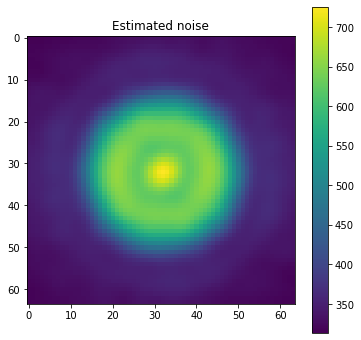

In [10]:
N_noise = 48
sigma_noise_estimated = estimate_noise_imgs(imgs0[:5000], nx_empty = N_noise, nx_final = nx).reshape([nx,nx])
plt.imshow(jnp.fft.fftshift(sigma_noise_estimated)); plt.colorbar()
plt.title('Estimated noise')

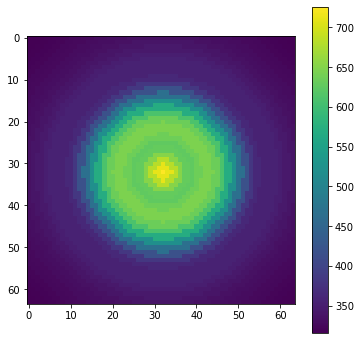

In [11]:
sigma_noise_avg = average_radially(sigma_noise_estimated, x_grid)
plt.imshow(jnp.fft.fftshift(sigma_noise_avg)); plt.colorbar()

In [12]:
sigma_noise = sigma_noise_avg.reshape(-1)

### Slice, loss, grad etc. functions 

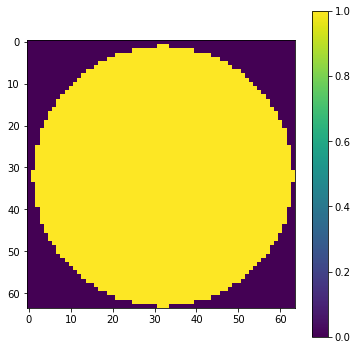

In [13]:
alpha = 1e-9

radius = 0.074
mask = create_3d_mask(x_grid, (0,0,0),radius)
mip_z(jnp.fft.fftshift(mask)); plt.colorbar()
M = 1/jnp.max(sigma_noise)**2 * jnp.ones([nx, nx, nx])

slice_func, slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
loss_func, loss_func_batched, loss_func_sum = get_loss_funcs(slice_func, alpha = alpha)
grad_loss_volume, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

In [ ]:
N_batches = 600000
#v_resid = get_volume_residual(v_rec, angles[N_train:N_train+2000], shifts[N_train:N_train+2000], ctf_params[N_train:N_train+2000], imgs_f[N_train:N_train+2000], sigma_noise, x_grid, slice_func_array, N_batches)

v_resid_pert = get_volume_residual(imgs_f, angles, sigma_noise, x_grid, slice_func_array, N_batches)
                 

#### 100 images

In [ ]:
plt.imshow(jnp.fft.fftshift(v_resid_pert[:,:,0]*mask[:,:,0])); plt.colorbar()

#### 1000 images

In [ ]:
plt.imshow(jnp.fft.fftshift(v_resid_pert[:,:,0]*mask[:,:,0])); plt.colorbar()

#### 10000 images

In [ ]:
plt.imshow(jnp.fft.fftshift(v_resid_pert[:,:,0]*mask[:,:,0])); plt.colorbar()

In [ ]:
v_resid_print = jnp.fft.fftshift(v_resid_pert*mask)
with mrcfile.new('../data/cryodrgn_jupyter/v_resid_64_pert.mrc', overwrite=True) as mrc:
    mrc.set_data(v_resid_print.astype(np.float32))